<a href="https://colab.research.google.com/github/sergfer26/Proyectos-II/blob/main/ejemplos/nn_linear_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo 1: Regresión lineal simple y multivarible

En este *notebook* pondremos en práctica el uso de redes neuroanles para tareas de regresión. En este caso usaremos una neurona con capa de salida lineal para primero encontrar la relación entre el peso y la altura de una muestra significativa de personas y en segundo lugar se encontrará la relación entre el peso y altura (variables independientes) con el índice de masa coporal (IMC).

**Objetivo**: 
1. Entrenar una red neuronal con capa de salida lineal que encuentre la relación entre el peso y la altura.

2. Entrenar una red neuronal con capa de salida lineal que encuentre la relación entre el peso y la altura como variables independientes con el IMC. 

In [44]:
import torch
import matplotlib
import pandas as pd
import numpy as np
from torch import nn
from torch import optim
from progressbar import ProgressBar
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
matplotlib.style.use('ggplot')

Usaremos la base de datos de kaggle: [weight-height.csv](https://www.kaggle.com/mustafaali96/weight-height) que contiene la altura y la masa de 5000 mujeres y 5000 hombres.

Para efectos prácticos tomaremos la base de datos de un repositorio público. En muchos casos es necesario descargar los datos.

In [45]:
url = 'https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv'
data = pd.read_csv(url, sep=',')
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [46]:
data.tail()

,Gender,Height,Weight
9995,Female,66.172652,136.777454
9996,Female,67.067155,170.867906
9997,Female,63.867992,128.475319
9998,Female,69.034243,163.852461
9999,Female,61.944246,113.649103


## Cambio de unidades.
Altura (*Height*) de pulgadas a metros.

In [47]:
data['Height'] = data['Height'].apply(lambda x: x/39.37)

Peso (*Weight*) de libras a kilos.

In [48]:
data['Weight'] = data['Weight'].apply(lambda x: x * .4536)

Adicionalmente calculamos el índice de masa corporal IMC (body mass weight).

In [49]:
data['IMC'] = data.apply(lambda x: (x['Weight']) / x['Height']**2, axis=1)

In [50]:
data.head()

,Gender,Height,Weight,IMC
0,Male,1.875718,109.722920,31.186187
1,Male,1.747064,73.624030,24.121373
2,Male,1.882400,96.499252,27.233278
3,Male,1.821970,99.811265,30.067469
4,Male,1.775001,93.600270,29.708438


## Análisis exploratorio de los datos

Trabajaremos con los datos que corresponden a las mujeres y el de los hombres quedara como ejercicio.

In [51]:
female_data = data[5000:]
female_data = female_data.reset_index(drop=True)
female_data.head()

,Gender,Height,Weight,IMC
0,Female,1.496336,46.307265,20.681933
1,Female,1.656846,64.096321,23.349039
2,Female,1.609576,59.440380,22.943446
3,Female,1.637795,58.138597,21.674314
4,Female,1.569548,58.868846,23.896618


### Variables

Graficamos al peso como función del peso.

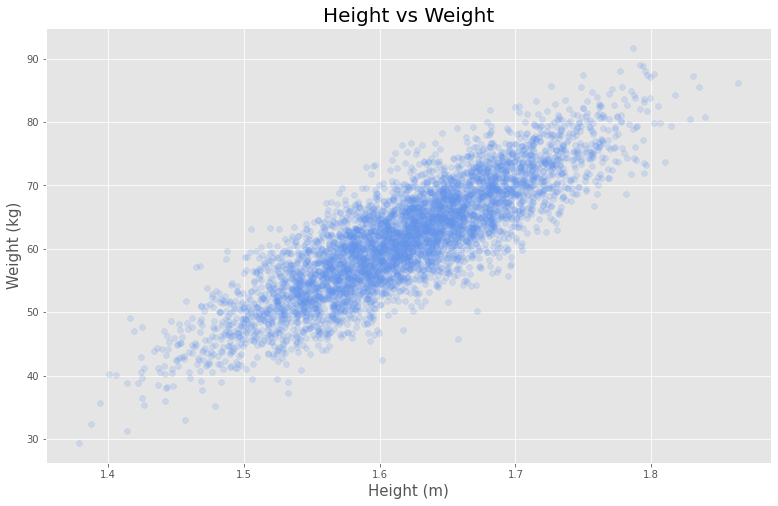

In [52]:
plt.figure(figsize=(13, 8))
plt.scatter(female_data['Height'], female_data['Weight'], color='cornflowerblue', alpha=0.2)
plt.title('Height vs Weight', size=20)
plt.xlabel('Height (m)', size=15)
plt.ylabel('Weight (kg)', size=15);

### Distibución de datos

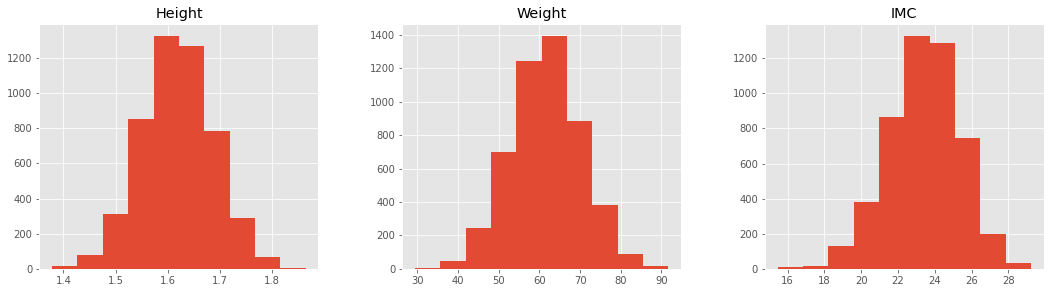

In [53]:
%matplotlib inline
female_data.hist(figsize=[18,4.5], layout=(1, 3))
plt.show()

In [54]:
female_data.describe()

,Height,Weight,IMC
count,5000.000000,5000.000000,5000.000000
mean,1.618206,61.626138,23.422037
std,0.068486,8.628591,1.948423
min,1.378286,29.347977,15.448961
25%,1.572122,55.762906,22.175783
50%,1.618769,61.742936,23.498991
75%,1.665318,67.500636,24.772306
max,1.864099,91.734800,29.245485


### Normalización de datos
$$\overline{x} = \frac{x - \hat\mu}{\hat \sigma}$$



In [55]:
mean_h = female_data['Height'].mean()
std_h = female_data['Height'].std()
female_data['Normalized_Height'] = female_data['Height'].apply(lambda x: (x - mean_h)/std_h)

In [56]:
mean_w = female_data['Weight'].mean()
std_w = female_data['Weight'].std()
female_data['Normalized_Weight'] = female_data['Weight'].apply(lambda x: (x - mean_w)/std_w)

In [57]:
mean_ = female_data['IMC'].mean()
std_ = female_data['IMC'].std()
female_data['Normalized_IMC'] = female_data['IMC'].apply(lambda x: (x - mean_)/std_)

## Diseño de base de datos de entrenamiento y prueba.

Separamos el *data frame* en dos partes, la primera ($90 \% $) corresponde a los datos de entrenamiento y la segunda ($10 \% $) corresponde a los datos de entrenamiento.

In [58]:
msk = np.random.rand(len(female_data)) < 0.6
training_data = female_data[msk]
test_data = female_data[~msk]

Es necesario divir crear instancias de *Dataset* que permitan manejar la información. Existen dos maneras:

1. Forma explícita.

In [97]:
class DataFrameDataset(Dataset):
  def __init__(self, data, x_names:list, y_name):
    X = data[x_names]
    Y = data[y_name] # -> una columna del dataframe
    self.X = torch.from_numpy(X.to_numpy()).to(dtype=torch.float32)
    self.Y = torch.from_numpy(Y.to_numpy()).to(dtype=torch.float32)

  def __len__(self):
    return self.Y.size()[0]

  def __getitem__(self, idx):
    x = self.X[idx, :]
    y = self.Y[idx]
    return x, y


In [60]:
dataset = DataFrameDataset(training_data, ['Normalized_Height'], ['Normalized_Weight'])
dataset.__getitem__(0)

(tensor([0.5642]), tensor([0.2863]))

  2. Forma directa (`TensorDataset`) 

In [61]:
# Training Dataset
X = training_data['Normalized_Height'].to_numpy()
Y = training_data['Normalized_Weight'].to_numpy()
features = torch.from_numpy(X).to(torch.float32) # razgos
targets = torch.from_numpy(Y).to(torch.float32) # valores reales
train_set = TensorDataset(features, targets)

# Test Dataset
X = test_data['Normalized_Height'].to_numpy()
Y = test_data['Normalized_Weight'].to_numpy()
features = torch.from_numpy(X).to(torch.float32) # razgos
targets = torch.from_numpy(Y).to(torch.float32) # valores reales
test_dataset = TensorDataset(features, targets)

Partimos a la mitad el `test_dataset` de tal forma que tengamos datos para la validación.

In [62]:
msk = np.random.rand(len(test_dataset)) < 0.6
val_set = torch.utils.data.Subset(test_dataset, np.where(msk)[0])
test_set = torch.utils.data.Subset(test_dataset, np.where(~msk)[0])

Observemos el tamaño de datos de cada conjunto.

In [63]:
n_train = len(train_set)
n_val = len(val_set)
n_test = len(test_set)

for n, name in zip([n_train, n_val, n_test], ['train', 'val', 'test']):
  print('# '+name+': {}'.format(n))

# train: 3027
# val: 1191
# test: 782


### DataLoader
Recordemos que esta clase en empaqueta a las particiones del conjunto de datos llamados *batches* o *mini-batches*.

$$\mathcal{D}_{train} = \mathcal{D}_{(1)} \cup \mathcal{D}_{(2)} \cup \cdots \cup \mathcal{D}_{(n_{batch})}$$

$$\mathcal{D}_{(j)} = X_{(j)} \times Y_{(j)} $$

Donde $n_{batch}$ es el número de particiones que se hizo sobre el conjunto de datos de entrenamiento original.

In [64]:
batch_size = 1
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=n_test)

## Regresión Lineal 

### Declaración del modelo

Para el primer objetivo, consideremos:

* $k:=$tamaño del *mini-batch* (4 en casi todas partes).

Sea $f_a(\cdot|\{w, b\}): \mathbb{R}^{k \times 1} \rightarrow \mathbb{R}$ con $a= \langle [1, 1], \{\text{Linear}\}\rangle$ la red neuronal que hará la tarea de regresión lineal. Claramente, podemos expresarla de la siguinete manera: 
$$f_a(X|\{w, b\})= wX + b, \quad X \in \mathbb{R}^{k \times 1}.$$

In [65]:
class LinearNet(nn.Module):
  def __init__(self,n_in, n_out):
    super(LinearNet, self).__init__()
    self.layer = nn.Linear(in_features=n_in, out_features=n_out, bias=True)
    self.in_features = n_in

  def forward(self, x):
    out = self.layer(x)
    return out

model = LinearNet(1,1)

### Función objetivo y optimizador.
En este caso usaremos la función de error cuadrático medio (*MSE*) para entrenar a la red neuronal.

$$MSE(w, b; Y, X) = \frac{1}{k}\sum_{x, y \in X, Y}(y -(wx+b))^2$$

Utilizaremos como optimizador `SGD` del módulo `torch.optim` que es la implementación del método de gradiente decendiente estocático.

``torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)``


In [66]:
cost = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0, nesterov=False)

### Entrenamiento

In [67]:
def update_parameters(model, dataloader, optimizer, criterion, train=True):
  running_loss = 0.0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    n = len(X)
    X = X.reshape((n, model.in_features)) # -> Corrección de tamaño, sólo es necesario en dim=1
    m = len(Y)
    Y = Y.reshape((m, 1)) # -> Corrección de tamaño
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
  return avg_loss

In [68]:
def train(model, train_loader, optimizer, criterion, epochs=100, val_loader=None, val=False):
  plt.figure(figsize=(20,8))
  plt.subplot(1, 2, 1)
  plt.title('Weight vs Height', size=24)
  plt.xlabel('Height')
  plt.xlabel('Weight')
  D_train = np.array(train_dataloader.dataset)
  X = D_train[:, 0]; Y = D_train[:, 1]
  plt.scatter(X, Y, alpha=0.1)
  if val:
    D_val = np.array(val_dataloader.dataset)
    X_ = D_val[:, 0]; Y_ = D_val[:, 1]
    plt.scatter(X_, Y_, alpha=0.2)

  w = float(model.layer.weight.detach().squeeze())
  b = float(model.layer.bias.detach().squeeze())
  plt.plot(X, w*X+b, color='green', lw=1)
  train_losses = list(); val_losses = list()
  bar = ProgressBar(max_value=epochs)
  alpha=0.1

  for epoch in range(epochs):
    train_loss = update_parameters(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    if val:
      val_loss = update_parameters(model, val_dataloader, None, criterion, train=False)
      val_losses.append(val_loss)

    w = float(model.layer.weight.detach().squeeze())
    b = float(model.layer.bias.detach().squeeze())
    if epoch == epochs-1:
      alpha=0.7
    plt.plot(X, w*X+b, alpha=alpha)
    bar.update(epoch)

  plt.subplot(1, 2, 2)
  plt.plot(train_losses)
  if val:
    plt.plot(val_losses)
    plt.legend(['train', 'val'], loc='upper right')
  plt.title('Cost vs epoch', size=24)
  plt.xlabel('epoch', size=18)
  plt.ylabel('cost', size=18)
  return train_losses, val_losses
  
    



 99% (99 of 100) |###################### | Elapsed Time: 0:01:46 ETA:   0:00:01

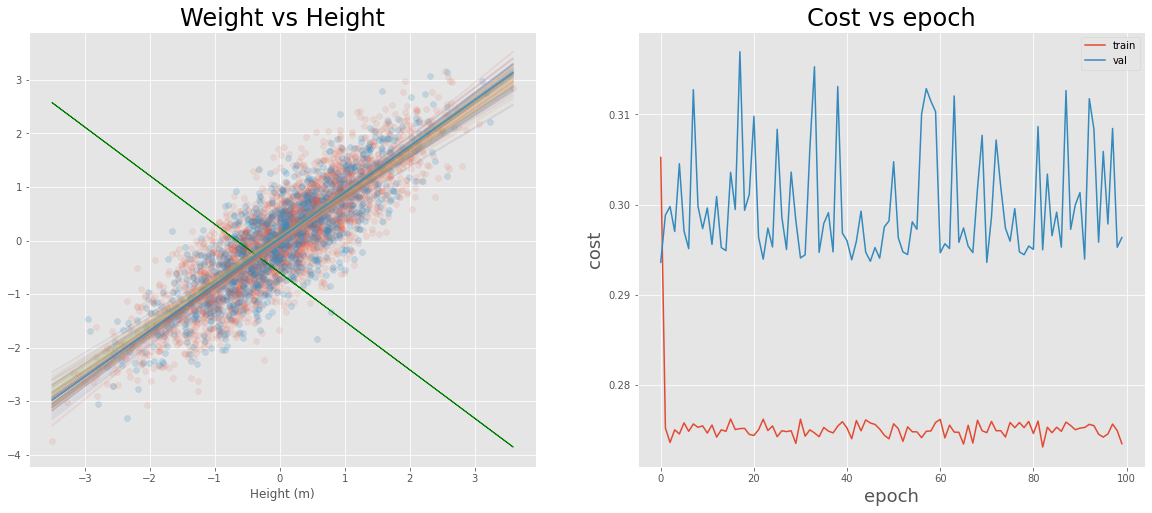

In [69]:
_, _ = train(model, train_dataloader, optimizer, cost, val_loader=val_dataloader, val=True)

In [80]:
data = next(iter(test_dataloader))
X, Y = data
n = len(X)
X = X.reshape((n, model.in_features)) # -> Corrección de tamaño
Y = Y.reshape((n, 1)) # -> Corrección de tamaño
pred = model(X)
error = cost(Y, pred)
print('error de prueba :{}'.format(error.item()))

error de prueba :0.29028505086898804


## Regresión multivariable

### Definición del *Dataset*

In [98]:
x_names = ['Normalized_Height', 'Normalized_Weight']
train_set = DataFrameDataset(training_data, x_names, 'Normalized_IMC')
test_dataset = DataFrameDataset(test_data, x_names, 'Normalized_IMC')

Separamos `test_dataset` en `test_set` y `val_set`.

In [99]:
msk = np.random.rand(len(test_dataset)) < 0.6
val_set = torch.utils.data.Subset(test_dataset, np.where(msk)[0])
test_set = torch.utils.data.Subset(test_dataset, np.where(~msk)[0])
n_test = len(test_set)

Convertimos los *Datasets* en instancias de *Dataloader*

In [100]:
batch_size = 1
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=n_test)

### Definición de la red neuronal

Sea $f_a(\cdot|\{w_1, w_2, b\}): \mathbb{R}^{k \times 2} \rightarrow \mathbb{R}$ con $a= \langle [2, 1], \{\text{Linear}\}\rangle$ la red neuronal que hará la tarea de regresión lineal. Claramente, podemos expresarla de la siguinete manera: 
$$f_a(X|\{w_1, w_2, b\})=   X \cdot [w_1, w_2]^{\top}+ b, \quad X \in \mathbb{R}^{k \times 2}.$$

In [101]:
model = LinearNet(2, 1)

### Función objetivo y optimizador

Los mismos que en la regresión lineal simple.

In [102]:
cost = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0, nesterov=False)

### Entrenamiento del modelo

In [128]:
epoch_loss = list()
val_loss = list()
epochs = 100

for epoch in range(epochs):
  loss_train = update_parameters(model, train_dataloader, optimizer, cost)
  loss_val = update_parameters(model, val_dataloader, None, cost, train=False)
  epoch_loss.append(loss_train)
  val_loss.append(loss_val)
  if epoch % 5 == 0:
    print('epoch {}, train loss {}, val loss {}'.format(epoch, loss_train, loss_val))

epoch 0, train loss 0.013556790894909933, val loss 0.014947396533574886
epoch 5, train loss 0.013722239619352632, val loss 0.016330964933754494
epoch 10, train loss 0.013610327076165994, val loss 0.016132931427090262
epoch 15, train loss 0.013382219414894515, val loss 0.016663252275466753
epoch 20, train loss 0.013575427889031827, val loss 0.015759477845982316
epoch 25, train loss 0.013505330742498187, val loss 0.015038649860558978
epoch 30, train loss 0.013304309085802208, val loss 0.015160857192039256
epoch 35, train loss 0.013493229523477058, val loss 0.015224733645526933
epoch 40, train loss 0.013699445848058503, val loss 0.01483167900924973
epoch 45, train loss 0.013300020518563998, val loss 0.01626360665837419
epoch 50, train loss 0.013514137308196941, val loss 0.015717069457277258
epoch 55, train loss 0.01375834263589719, val loss 0.015894992847463436
epoch 60, train loss 0.013476455178283062, val loss 0.016001930029346068
epoch 65, train loss 0.013500770164135537, val loss 0.01

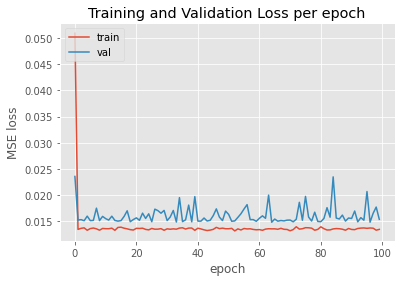

In [104]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss per epoch')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Gráfica de modelo obtenido

In [110]:
train_dataloader.dataset.__getitem__(0)

(tensor([0.5642, 0.2863]), tensor(-0.0375))

In [113]:
x_tensor, target_tensor = train_dataloader.dataset[:]
D_train = np.array(x_tensor)
X = D_train[:, 0]; Y = D_train[:, 1]; Z = np.array(target_tensor)

x_tensor, target_tensor = test_dataloader.dataset[:]
D_val = np.array(x_tensor)
X_ = D_val[:, 0]; Y_ = D_val[:, 1]; Z_ = np.array(target_tensor)

In [118]:
model.layer.weight[0, 0]

tensor(-1.0158, grad_fn=<SelectBackward>)

In [124]:
w1 = float(model.layer.weight[0, 0].detach().squeeze())
w2 = float(model.layer.weight[0, 1].detach().squeeze())
b = float(model.layer.bias.detach().squeeze())
xx, yy = np.meshgrid(range(-4, 4), range(-4, 4))
pred = w1 * xx + w2* yy +b

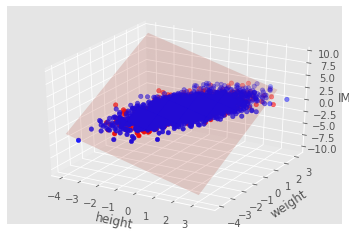

In [126]:
plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(xx, yy, pred, alpha=0.2);
ax = plt.gca()
ax.set_xlabel('height')
ax.set_ylabel('weight')
ax.set_zlabel('IMC')
ax.scatter(X_, Y_, Z_, color='r')
ax.scatter(X, Y, Z, color='b')
plt.show()

### Prueba del modelo

In [127]:
data = next(iter(test_dataloader))
X, Y = data
n = len(Y)
Y = Y.reshape((n, 1)) # -> Corrección de tamaño
pred = model(X)
error = cost(Y, pred)
print('error de prueba :{}'.format(error.item()))

error de prueba :0.011272042989730835
